# 이미지 전처리 및 Data Augmentation

In [4]:
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models

from config import path

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cpu')

In [7]:
def display_images_center_crop(image_paths, title, max_images=4):
    plt.figure(figsize=(12, 3))
    for i, image_path in enumerate(image_paths[:max_images]):
        image = Image.open(image_path)
        width, height = image.size

        new_edge_length = min(width, height)
        left = (width - new_edge_length)/2
        top = (height - new_edge_length)/2
        right = (width + new_edge_length)/2
        bottom = (height + new_edge_length)/2

        image_cropped = image.crop((10, 20, width-10, height-15))

        plt.subplot(1, max_images, i+1)
        plt.imshow(image_cropped)
        plt.title(title)
        plt.axis('off')
    plt.show()

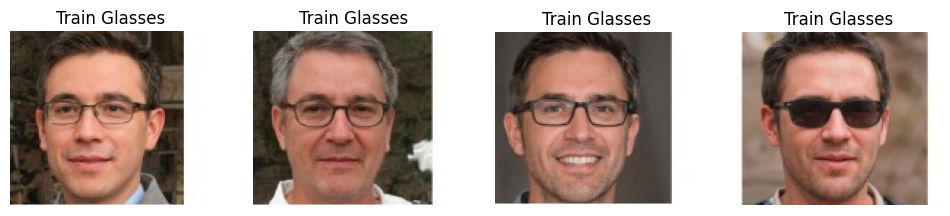

Train Glasses 총 이미지 수: 52


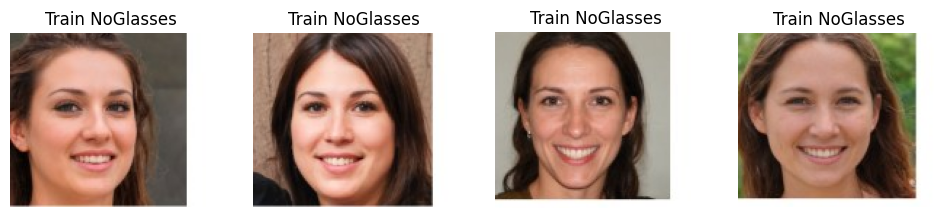

Train NoGlasses 총 이미지 수: 52


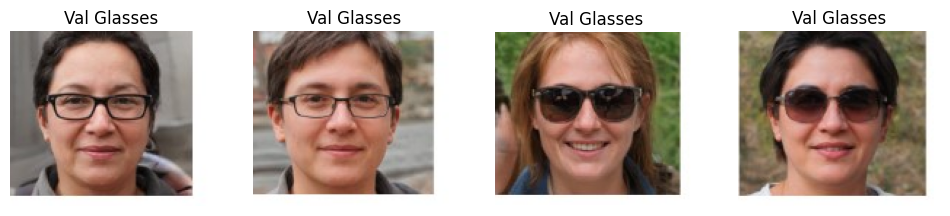

Val Glasses 총 이미지 수: 20


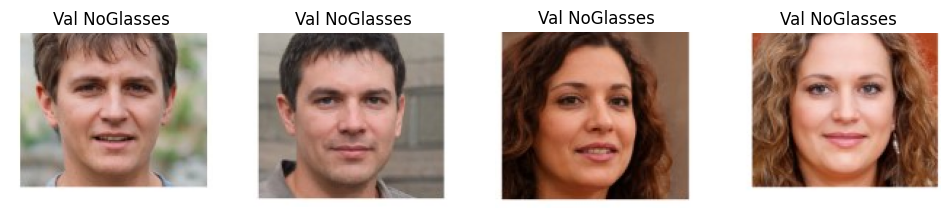

Val NoGlasses 총 이미지 수: 20


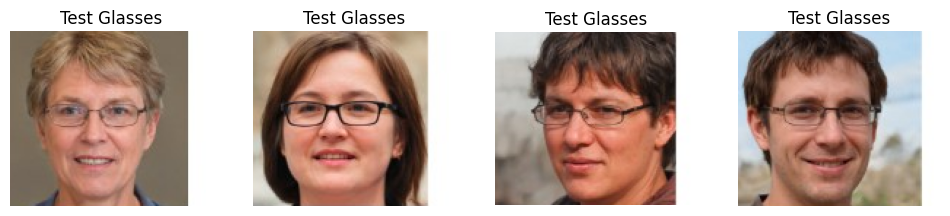

Test Glasses 총 이미지 수: 10


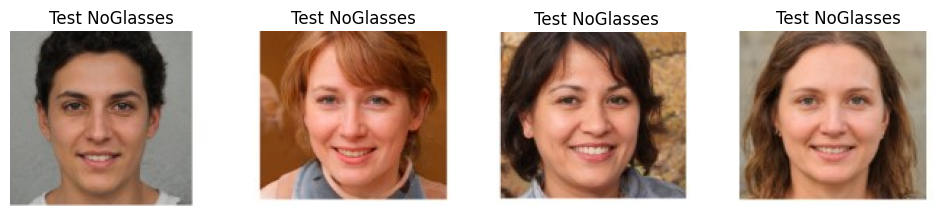

Test NoGlasses 총 이미지 수: 10


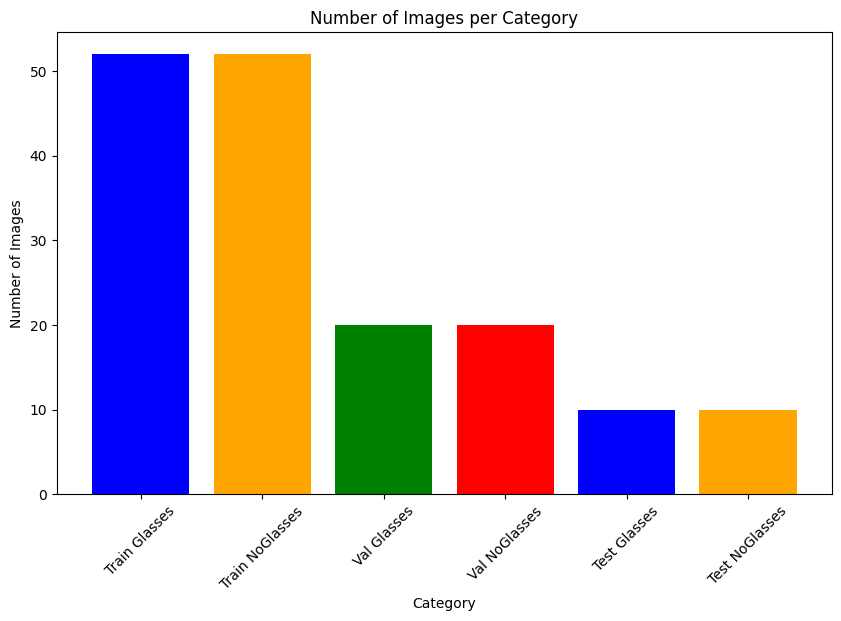

In [8]:
categories = ['Train Glasses', 'Train NoGlasses', 'Val Glasses', 'Val NoGlasses', 'Test Glasses', 'Test NoGlasses']

for category in categories:
    image_paths = glob.glob(f'/Users/taeyoun/Downloads/DeepLearning/project/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/2/{category.lower().replace(" ", "/")}/*')
    display_images_center_crop(image_paths, category)  # 함수 호출 수정
    print(f"{category} 총 이미지 수: {len(image_paths)}")

# 바 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(categories, [len(glob.glob(f'/Users/taeyoun/Downloads/DeepLearning/project/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/2/{category.lower().replace(" ", "/")}/*')) for category in categories], color=['blue', 'orange', 'green', 'red'])
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

### 데이터 Augmentation

In [9]:

transform = transforms.Compose([
    transforms.CenterCrop(128),  # 이미지 Crop
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.RandomHorizontalFlip(),  # 이미지를 무작위로 수평 뒤집기
    transforms.RandomRotation(30),  # 이미지를 최대 30도까지 무작위로 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 이미지의 밝기, 대비, 채도, 색조를 무작위로 변경
    transforms.RandomGrayscale(p=0.2),  # 20% 확률로 이미지를 그레이스케일로 변환
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 정규화
])

# 데이터셋 로드 및 데이터 로더 생성
train_dataset = ImageFolder('/Users/taeyoun/Downloads/DeepLearning/project/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/2/train', transform=transform)
val_dataset = ImageFolder('/Users/taeyoun/Downloads/DeepLearning/project/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/2/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):  # ImageNet 데이터셋의 클래스 수는 1000
        super(AlexNet, self).__init__()
        # Convolutional layer
        self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2)
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        # Max pooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        # Fully connected layer
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)  # 여기서 6*6은 입력 이미지 크기에 따라 달라질 수 있음 (ex. Input Image224x224)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)
        # Dropout layer
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(F.relu(self.conv5(x)))
        # Flatten
        x = x.view(x.size(0), 256 * 6 * 6)  # 배치 차원 유지하면서 Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)  # 최종 출력에는 활성화 함수를 적용하지 않음
        return x

In [11]:
net = AlexNet(num_classes=2)  # 예: 이진 분류 문제의 경우
net = net.to(device)

In [12]:
# 손실 함수 및 최적화기
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [13]:
# 정확도 계산 함수
def calculate_accuracy(loader, model):
    """주어진 데이터 로더에 대한 모델의 정확도를 계산합니다."""
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [14]:
# 학습/검증 손실과 검증 정확도를 저장할 리스트
train_losses = []
val_losses = []
val_accuracies = []

# 모델 학습
num_epochs = 20
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # 매 에포크마다 평균 학습 손실 계산
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)  # 리스트에 추가

    # 검증 손실 계산
    val_loss = 0.0
    net.eval()  # 모델을 평가 모드로 설정
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)  # 리스트에 추가

    # 검증 정확도 계산
    val_accuracy = calculate_accuracy(val_loader, net)
    val_accuracies.append(val_accuracy)  # 리스트에 추가

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%')

print('Finished Training')

Epoch 1, Train Loss: 0.695861, Val Loss: 0.692999, Validation Accuracy: 50.00%
Epoch 2, Train Loss: 0.693423, Val Loss: 0.688245, Validation Accuracy: 50.00%
Epoch 3, Train Loss: 0.643228, Val Loss: 0.681007, Validation Accuracy: 52.50%
Epoch 4, Train Loss: 0.531990, Val Loss: 0.860716, Validation Accuracy: 57.50%
Epoch 5, Train Loss: 0.451504, Val Loss: 0.827788, Validation Accuracy: 60.00%
Epoch 6, Train Loss: 0.389519, Val Loss: 1.753978, Validation Accuracy: 52.50%
Epoch 7, Train Loss: 0.442746, Val Loss: 1.055099, Validation Accuracy: 75.00%
Epoch 8, Train Loss: 0.309287, Val Loss: 1.678068, Validation Accuracy: 70.00%
Epoch 9, Train Loss: 0.280808, Val Loss: 0.870404, Validation Accuracy: 67.50%
Epoch 10, Train Loss: 0.185088, Val Loss: 0.609411, Validation Accuracy: 82.50%
Epoch 11, Train Loss: 0.120599, Val Loss: 1.680790, Validation Accuracy: 85.00%
Epoch 12, Train Loss: 0.165714, Val Loss: 0.354688, Validation Accuracy: 82.50%
Epoch 13, Train Loss: 0.194363, Val Loss: 0.73338

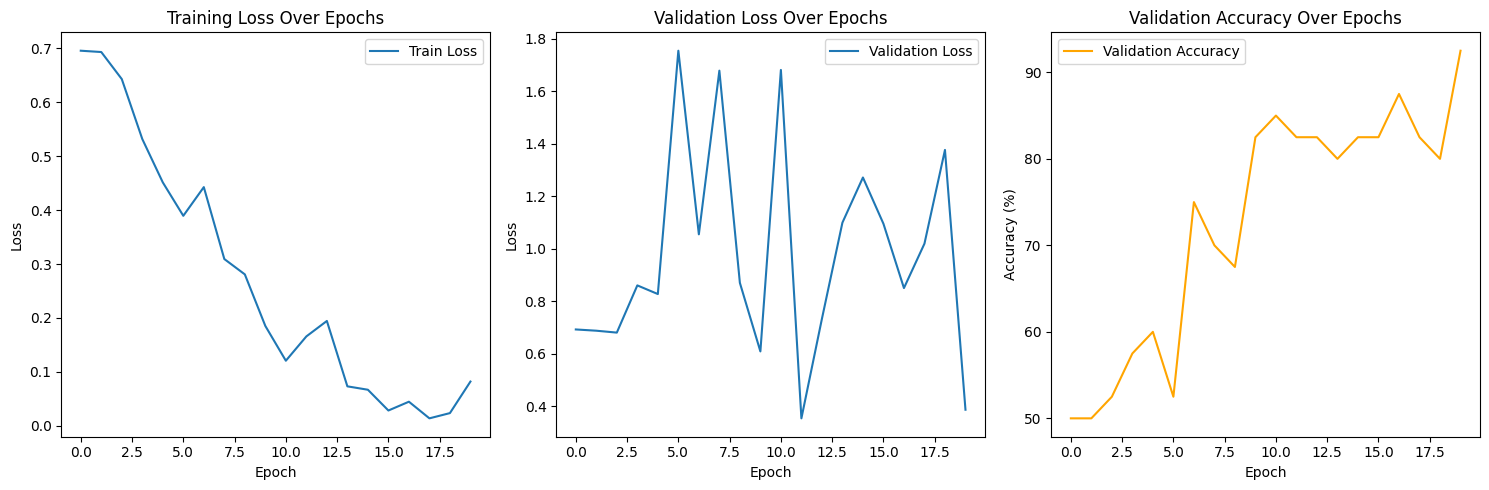

In [15]:
# 학습 손실과 검증 정확도 그래프 그리기
plt.figure(figsize=(15, 5))

# 학습 손실 그래프
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# 검증 정확도 그래프
plt.subplot(1, 3, 2)
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

# 검증 정확도 그래프
plt.subplot(1, 3, 3)
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    width, height = image.size

    # 중앙에서 128x128 크기로 크롭하기 위한 시작점과 끝점 계산
    left = (width - 128) / 2
    top = (height - 128) / 2
    right = (width + 128) / 2
    bottom = (height + 128) / 2

    # 계산된 위치를 기반으로 이미지 크롭
    image_cropped = image.crop((left, top, right, bottom))

    # 크롭된 이미지에 추가 변환 적용 (예: 크기 조정, 텐서 변환, 정규화 등)
    return transform(image_cropped), image_cropped

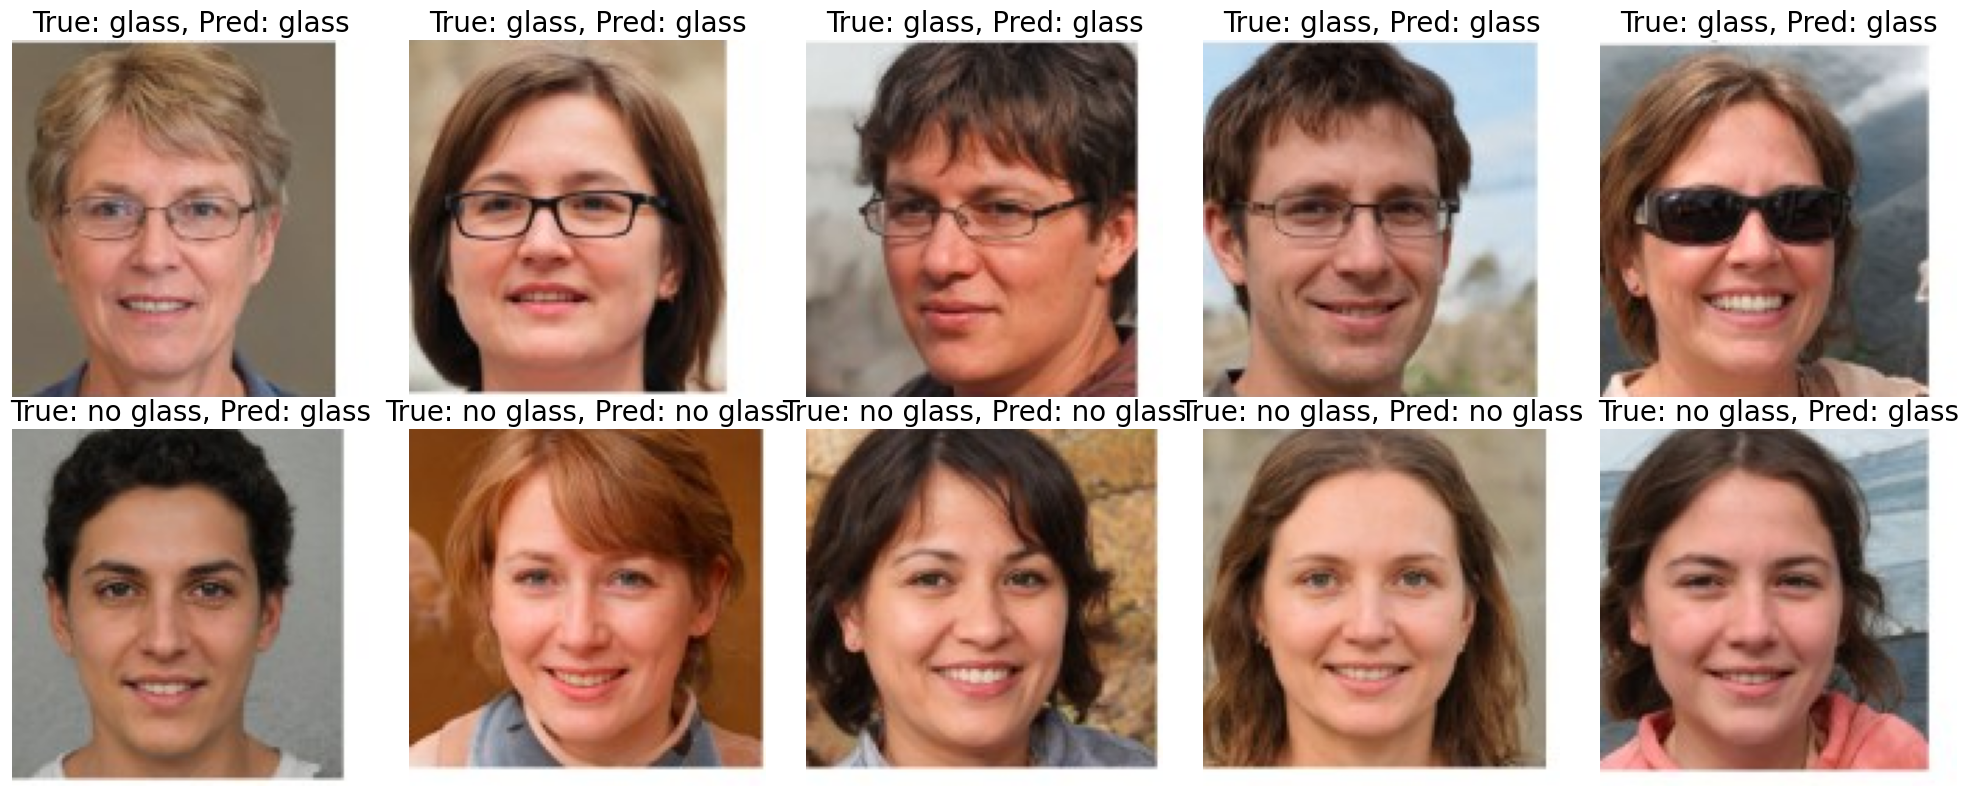

In [19]:
# 클래스별 폴더 경로
class_folders = {
    'glass': '/Users/taeyoun/Downloads/DeepLearning/project/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/2/test/glasses',
    'no glass': '/Users/taeyoun/Downloads/DeepLearning/project/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/2/test/noglasses'
}

# 각 클래스별로 5장의 이미지 추론 및 시각화
plt.figure(figsize=(20, 8))

# subplot 인덱스를 위한 카운터
counter = 1

for class_name, folder_path in class_folders.items():
    # 해당 클래스의 이미지 경로 가져오기
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[:5]  # 첫 5장 선택

    for image_path in selected_paths:
        image, image_cropped = load_and_transform_image(image_path, transform)
        image_unsqueeze = image.unsqueeze(0)  # 배치 차원 추가
        image_unsqueeze = image_unsqueeze.to(device)
        # 모델을 사용한 추론
        output = net(image_unsqueeze)
        _, predicted = torch.max(output, 1)
        prediction = 'glass' if predicted.item() == 0 else 'no glass'

        # 결과 시각화
        plt.subplot(2, 5, counter)
        plt.imshow(image_cropped)
        plt.title(f'True: {class_name}, Pred: {prediction}', fontsize=20)
        plt.axis('off')

        counter += 1  # subplot 인덱스 업데이트

plt.tight_layout()
plt.show()